# AbXtract - Comprehensive Testing and Examples

This notebook demonstrates the complete functionality of the AbXtract package for antibody descriptor calculations.

## 📚 Table of Contents
1. [Setup and Imports](#setup)
2. [Configuration Testing](#config)
3. [Individual Calculator Testing](#individual)
4. [Sequence-based Analysis](#sequence)
5. [Structure-based Analysis](#structure)
6. [Combined Analysis](#combined)
7. [Batch Processing](#batch)
8. [Visualization Examples](#viz)
9. [Export and Import](#export)

## 1. Setup and Imports {#setup}

Let's start by importing all necessary modules and setting up the environment.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib
plt.style.use('default')
sns.set_palette("husl")

print("📦 Basic imports successful")

📦 Basic imports successful


In [2]:
# Check what's actually available
import sys
print("Python path:")
for p in sys.path:
    print(f"  {p}")

# Check if AbXtract directory is accessible
import os
abxtract_path = "/home/HX46_FR5/repo_perso/AbXtract"
print(f"\nAbXtract path exists: {os.path.exists(abxtract_path)}")
print(f"AbXtract path in sys.path: {abxtract_path in sys.path}")

Python path:
  /opt/conda/envs/abxtract/lib/python39.zip
  /opt/conda/envs/abxtract/lib/python3.9
  /opt/conda/envs/abxtract/lib/python3.9/lib-dynload
  
  /opt/conda/envs/abxtract/lib/python3.9/site-packages

AbXtract path exists: True
AbXtract path in sys.path: False


In [3]:
import sys
import os
sys.path.insert(0, '/home/HX46_FR5/repo_perso/AbXtract')

# Now try the imports
try:
    from AbXtract import *
    print("✅ AbXtract imported successfully!")
except ImportError as e:
    print(f"❌ Still having issues: {e}")

✅ AbXtract imported successfully!


In [4]:
# Import AbXtract modules
try:
    from AbXtract import AntibodyDescriptorCalculator, Config, load_config
    from AbXtract.sequence import (
        SequenceLiabilityAnalyzer,
        BashourDescriptorCalculator,
        PeptideDescriptorCalculator,
        AntibodyNumbering
    )
    from AbXtract.structure import (
        SASACalculator,
        ChargeAnalyzer,
        DSSPAnalyzer,
        PropkaAnalyzer,
        ArpeggioAnalyzer
    )
    from AbXtract.utils import (
        read_fasta,
        write_fasta,
        parse_sequence,
        validate_sequence
    )
    
    print("🚀 AbXtract imports successful!")
    
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please make sure AbXtract is installed and in your Python path")
    sys.exit(1)

🚀 AbXtract imports successful!


In [5]:
# Set up test data paths
BASE_DIR = Path.cwd() # pass to ../ chmod ../
DATA_DIR = BASE_DIR / "data" / "test"
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Define test file paths
FASTA_FILE = DATA_DIR / "test_antibody.fasta"
PDB_FILE = DATA_DIR / "test.pdb"  # User will provide this
RESULTS_DIR = DATA_DIR / "results"
RESULTS_DIR.mkdir(exist_ok=True)

print(f"📁 Test data directory: {DATA_DIR}")
print(f"📁 Results directory: {RESULTS_DIR}")

📁 Test data directory: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test
📁 Results directory: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test/results


## 2. Configuration Testing {#config}

Test the configuration system and external tool availability.

In [6]:
# Test default configuration
config = Config()
print("🔧 Default Configuration:")
print(f"  Numbering scheme: {config.numbering_scheme}")
print(f"  pH: {config.pH}")
print(f"  Temperature: {config.temperature}°C")
print(f"  Output format: {config.output_format}")
print(f"  Verbose: {config.verbose}")

🔧 Default Configuration:
  Numbering scheme: imgt
  pH: 7.0
  Temperature: 25.0°C
  Output format: csv
  Verbose: True


In [7]:
# Check external tool availability
tool_status = config.check_external_tools()
print("🛠️ External Tool Status:")
for tool, available in tool_status.items():
    status = "✅" if available else "❌"
    print(f"  {tool}: {status}")

# Count available tools
available_count = sum(tool_status.values())
total_count = len(tool_status)
print(f"\n📊 {available_count}/{total_count} external tools available")

reduce not found at reduce


🛠️ External Tool Status:
  dssp: ✅
  propka: ✅
  arpeggio: ✅
  reduce: ❌
  muscle: ✅

📊 4/5 external tools available


In [8]:
# Test custom configuration
custom_config = Config.from_dict({
    'pH': 7.4,
    'numbering_scheme': 'kabat',
    'verbose': True,
    'calculate_dssp': tool_status.get('dssp', False),
    'calculate_propka': tool_status.get('propka', False),
    'calculate_arpeggio': tool_status.get('arpeggio', False)
})

print("🎛️ Custom Configuration created with optimal settings")
print(f"  DSSP enabled: {custom_config.calculate_dssp}")
print(f"  PROPKA enabled: {custom_config.calculate_propka}")
print(f"  Arpeggio enabled: {custom_config.calculate_arpeggio}")

🎛️ Custom Configuration created with optimal settings
  DSSP enabled: True
  PROPKA enabled: True
  Arpeggio enabled: True


## 3. Test Sequences Setup

Let's create our test sequences and save them to a FASTA file.

In [9]:
# Test antibody sequences (based on therapeutic antibodies)
# Heavy chain: Includes realistic VH domain + human IgG1 constant region
HEAVY_SEQUENCE = (
    "QVQLVQSGAEVKKPGASVKVSCKASGGTFSSYAISWVRQAPGQGLEWMG"
    "GIIPIFGTANYAQKFQGRVTITADESTSTAYMELSSLRSEDTAVYYCAR"
    "SHYGLDYWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKD"
    "YFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQT"
    "YICNVNHKPSNTKVDKKVEPKSCDKTHTCPPCPAPELLGGPSVFLFPPK"
    "PKDTLMISRTPEVTCVVVDVSHEDPEVKFNWYVDGVEVHNAKTKPREEQ"
    "YASTYRVVSVLTVLHQDWLNGKEYKCKVSNKALPAPIEKTISKAKGQPR"
    "EPQVYTLPPSRDELTKNQVSLTCLVKGFYPSDIAVEWESNGQPENNYK"
    "TTPPVLDSDGSFFLYSKLTVDKSRWQQGNVFSCSVMHEALHNHYTQKS"
    "LSLSPGK"
)

# Light chain: Includes realistic VL domain + human kappa constant region  
LIGHT_SEQUENCE = (
    "DIQMTQSPSSLSASVGDRVTITCRASHSISSYLAWYQQKPGKAPKLLIY"
    "AASSLQSGVPSRFSGSGSGTDFTLTISSLQPEDFATYYCQQSYSTPLTF"
    "GGGTKVEIKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKV"
    "QWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYAC"
    "EVTHQGLSSPVTKSFNRGEC"
)

print(f"🧬 Heavy chain length: {len(HEAVY_SEQUENCE)} aa")
print(f"🧬 Light chain length: {len(LIGHT_SEQUENCE)} aa")
print(f"🧬 Total antibody length: {len(HEAVY_SEQUENCE + LIGHT_SEQUENCE)} aa")

🧬 Heavy chain length: 446 aa
🧬 Light chain length: 214 aa
🧬 Total antibody length: 660 aa


In [10]:
# Validate sequences
heavy_valid, heavy_msg = validate_sequence(HEAVY_SEQUENCE)
light_valid, light_msg = validate_sequence(LIGHT_SEQUENCE)

print("✅ Sequence Validation:")
print(f"  Heavy chain: {'✅ Valid' if heavy_valid else '❌ Invalid - ' + heavy_msg}")
print(f"  Light chain: {'✅ Valid' if light_valid else '❌ Invalid - ' + light_msg}")

if not (heavy_valid and light_valid):
    raise ValueError("Test sequences are invalid!")

✅ Sequence Validation:
  Heavy chain: ✅ Valid
  Light chain: ✅ Valid


In [11]:
# Create FASTA file for testing
test_sequences = {
    "Test_Antibody_Heavy_Chain": HEAVY_SEQUENCE,
    "Test_Antibody_Light_Chain": LIGHT_SEQUENCE
}

write_fasta(test_sequences, FASTA_FILE)
print(f"💾 Test FASTA file created: {FASTA_FILE}")

# Verify we can read it back
loaded_sequences = read_fasta(FASTA_FILE)
print(f"📖 Loaded {len(loaded_sequences)} sequences from FASTA:")
for seq_id, seq in loaded_sequences.items():
    print(f"  {seq_id}: {len(seq)} aa")

💾 Test FASTA file created: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test/test_antibody.fasta
📖 Loaded 2 sequences from FASTA:
  Test_Antibody_Heavy_Chain: 446 aa
  Test_Antibody_Light_Chain: 214 aa


## 4. Individual Calculator Testing {#individual}

Test each calculator module individually to ensure they work correctly.

In [12]:
# Test Liability Analyzer
print("🔍 Testing Sequence Liability Analyzer...")

liability_analyzer = SequenceLiabilityAnalyzer()
liability_results = liability_analyzer.analyze(
    heavy_sequence=HEAVY_SEQUENCE,
    light_sequence=LIGHT_SEQUENCE
)

print(f"  Found {liability_results['count']} liabilities")
print(f"  Total possible liabilities checked: {liability_results['total_possible']}")

if liability_results['liabilities']:
    print("\n  Detected liabilities:")
    for liability in liability_results['liabilities'][:5]:  # Show first 5
        print(f"    - {liability['name']} in chain {liability['chain']} at position {liability['start_position']}")
        print(f"      Sequence: {liability['sequence']}")
else:
    print("  ✅ No sequence liabilities detected")

🔍 Testing Sequence Liability Analyzer...
  Found 4 liabilities
  Total possible liabilities checked: 12

  Detected liabilities:
    - Met oxidation (M) in chain L at position [4, ' ']
      Sequence: M
    - Trp oxidation (W) in chain H at position [118, ' ']
      Sequence: W
    - Trp oxidation (W) in chain L at position [41, ' ']
      Sequence: W
    - Polyreactivity (RR VG VV VVV WW WWW WXW) in chain L at position [15, ' ']
      Sequence: VG


In [13]:
# Test Bashour Descriptor Calculator
print("📊 Testing Bashour Descriptor Calculator...")

bashour_calc = BashourDescriptorCalculator()
bashour_results = bashour_calc.calculate({
    'Heavy': HEAVY_SEQUENCE,
    'Light': LIGHT_SEQUENCE
})

print(f"  Calculated {len(bashour_results.columns)} descriptors for {len(bashour_results)} chains")
print(f"  Columns: {list(bashour_results.columns[:10])}...")  # First 10 columns

# Show some key descriptors
if not bashour_results.empty:
    print("\n  Key descriptors:")
    display(bashour_results)

📊 Testing Bashour Descriptor Calculator...
  Calculated 38 descriptors for 2 chains
  Columns: ['SeqID', 'Seq', 'Dataset', 'Molecular Weight', 'Seq Length', 'Average Residue Weight', 'pI', 'Charges (all pH values)', 'Charge_pH_1', 'Charge_pH_2']...

  Key descriptors:


,SeqID,Seq,Dataset,Molecular Weight,Seq Length,Average Residue Weight,pI,Charges (all pH values),Charge_pH_1,Charge_pH_2,...,Hydrophobicity,Hydrophobic moment,Aromatic content,Tiny content,Small content,Aliphatic content,Nonpolar content,Polar content,Basic content,Acidic content
0,Heavy,QVQLVQSGAEVKKPGASVKVSCKASGGTFSSYAISWVRQAPGQGLE...,Analysis,48473.79784,446,108.685645,8.063751,"{1: 53.90808431508109, 2: 53.211917551029444, ...",53.908084,53.211918,...,0.032780,0.702313,11.210762,34.977578,59.641256,25.112108,52.017937,47.982063,11.883408,8.520179
1,Light,DIQMTQSPSSLSASVGDRVTITCRASHSISSYLAWYQQKPGKAPKL...,Analysis,23173.78954,214,108.288736,7.590943,"{1: 22.931097096179496, 2: 22.43859614650606, ...",22.931097,22.438596,...,-0.000047,0.713866,10.747664,40.186916,58.411215,23.831776,47.196262,52.803738,10.280374,8.411215


In [14]:
# Test Antibody Numbering
print("🔢 Testing Antibody Numbering...")

numbering = AntibodyNumbering(scheme='imgt')
try:
    # Number heavy chain
    heavy_numbered = numbering.number_sequence(HEAVY_SEQUENCE, 'H')  # Use VH portion only
    print(f"  Heavy chain numbered: {len(heavy_numbered)} positions")
    
    # Show first few positions
    print("  First 10 positions:")
    for i, ((pos, ins), aa) in enumerate(heavy_numbered[:10]):
        print(f"    {pos:3d}{ins} {aa}")
    
    # Get CDR sequences
    cdrs = numbering.get_cdr_sequences(heavy_numbered, 'H')
    print(f"\n  Identified {len(cdrs)} CDRs:")
    for cdr_name, cdr_seq in cdrs.items():
        print(f"    {cdr_name}: {cdr_seq}")
        
except Exception as e:
    print(f"  ⚠️ Numbering failed (may need ANARCI installed): {e}")

🔢 Testing Antibody Numbering...
  Heavy chain numbered: 116 positions
  First 10 positions:
      1  Q
      2  V
      3  Q
      4  L
      5  V
      6  Q
      7  S
      8  G
      9  A
     11  E

  Identified 3 CDRs:
    cdrh1: GGTFSSYA
    cdrh2: IIPIFGTA
    cdrh3: ARSHYGLDY


In [15]:
# Test Peptide Descriptor Calculator
print("🧪 Testing Peptide Descriptor Calculator...")

peptide_calc = PeptideDescriptorCalculator()
peptide_results = peptide_calc.calculate_all(
    heavy_sequence=HEAVY_SEQUENCE,
    light_sequence=LIGHT_SEQUENCE
)

print(f"  Calculated descriptors for {len(peptide_results)} chains")
print(f"  Total descriptors per chain: {len(peptide_results.columns)}")

# Show some interesting descriptors
if not peptide_results.empty:
    print("\n  Sample descriptors:")
    display(peptide_results)


Failed to calculate protpy descriptors: 'numpy.ndarray' object is not callable
Failed to calculate protpy descriptors: 'numpy.ndarray' object is not callable


🧪 Testing Peptide Descriptor Calculator...
  Calculated descriptors for 2 chains
  Total descriptors per chain: 174

  Sample descriptors:


,chain,sequence,length,aliphatic_index,boman,charge_pH7.4,isoelectric_point,instability_index,molecular_weight,molar_extinction_reduced,...,protpy_aa_N,protpy_aa_P,protpy_aa_Q,protpy_aa_R,protpy_aa_S,protpy_aa_T,protpy_aa_V,protpy_aa_W,protpy_aa_Y,hydrophobic_moment_w5_a100
0,Heavy,QVQLVQSGAEVKKPGASVKVSCKASGGTFSSYAISWVRQAPGQGLE...,446,71.591928,1.358004,3.765413,8.321377,46.153363,48473.79784,NaN,...,"0 3.363 Name: N, dtype: float64","0 7.623 Name: P, dtype: float64","0 4.26 Name: Q, dtype: float64","0 2.242 Name: R, dtype: float64","0 12.108 Name: S, dtype: float64","0 7.848 Name: T, dtype: float64","0 10.09 Name: V, dtype: float64","0 1.794 Name: W, dtype: float64","0 4.26 Name: Y, dtype: float64",0.864565
1,Light,DIQMTQSPSSLSASVGDRVTITCRASHSISSYLAWYQQKPGKAPKL...,214,67.429907,1.643505,0.375036,7.847862,57.210748,23173.78954,NaN,...,"0 2.336 Name: N, dtype: float64","0 5.14 Name: P, dtype: float64","0 6.542 Name: Q, dtype: float64","0 2.804 Name: R, dtype: float64","0 16.822 Name: S, dtype: float64","0 8.411 Name: T, dtype: float64","0 6.542 Name: V, dtype: float64","0 0.935 Name: W, dtype: float64","0 4.673 Name: Y, dtype: float64",1.029839


## 5. Sequence-based Analysis {#sequence}

Now let's test the main AntibodyDescriptorCalculator with sequence-only analysis.

In [16]:
# Initialize main calculator
print("🚀 Initializing AntibodyDescriptorCalculator...")



calc = AntibodyDescriptorCalculator(config=custom_config)
print("✅ Calculator initialized successfully")

# Check calculator status
if hasattr(calc, 'get_calculator_status'):
    status = calc.get_calculator_status()
    print("\n📋 Calculator Status:")
    for category, calculators in status.items():
        if category != 'external_tools':
            print(f"  {category}:")
            for calc_name, calc_info in calculators.items():
                enabled = "✅" if calc_info.get('enabled', False) else "⚪"
                print(f"    {enabled} {calc_name}: {calc_info.get('description', '')}")

🚀 Initializing AntibodyDescriptorCalculator...


reduce not found at reduce
Missing external tools: reduce
Some analyses may not be available


✅ Calculator initialized successfully


In [17]:
# Run sequence-only analysis
print("🧬 Running sequence-based analysis...")

sequence_results = calc.calculate_sequence_descriptors(
    heavy_sequence=HEAVY_SEQUENCE,
    light_sequence=LIGHT_SEQUENCE,
    sequence_id="TestAb_Sequence"
)

print(f"✅ Sequence analysis completed!")
print(f"   Results shape: {sequence_results.shape}")
print(f"   Columns: {len(sequence_results.columns)}")

# Display the first few columns
print("\n📊 First 10 columns:")
display_cols = list(sequence_results.columns)[:10]
print(sequence_results[display_cols].T)

🧬 Running sequence-based analysis...


Failed to calculate protpy descriptors: 'numpy.ndarray' object is not callable
Failed to calculate protpy descriptors: 'numpy.ndarray' object is not callable


✅ Sequence analysis completed!
   Results shape: (1, 254)
   Columns: 254

📊 First 10 columns:
                                                                       0
SeqID                                                    TestAb_Sequence
Type                                                            Antibody
Heavy_Length                                                         446
Light_Length                                                         214
H                      [((1,  ), Q), ((2,  ), V), ((3,  ), Q), ((4,  ...
L                      [((1,  ), D), ((2,  ), I), ((3,  ), Q), ((4,  ...
Total_Liabilities                                                      0
N_Glycosylation_Sites                                                  0
Deamidation_Sites                                                      0
Oxidation_Sites                                                        0


In [18]:
# Analyze key sequence metrics
print("🔍 Key Sequence Metrics:")

result_row = sequence_results.iloc[0]

# Basic properties
print(f"  Antibody Type: {result_row.get('Type', 'Unknown')}")
print(f"  Heavy Chain Length: {result_row.get('Heavy_Length', 'N/A')} aa")
print(f"  Light Chain Length: {result_row.get('Light_Length', 'N/A')} aa")

# Liabilities
total_liabilities = result_row.get('Total_Liabilities', 0)
print(f"  Total Liabilities: {total_liabilities}")

# Physicochemical properties
molecular_weight = result_row.get('Molecular Weight', 'N/A')
print(f"  Molecular Weight: {molecular_weight} Da")

pi_value = result_row.get('pI', 'N/A')
print(f"  Isoelectric Point: {pi_value}")

instability = result_row.get('Instability Index', 'N/A')
# stability = "Stable" if instability < 40 else "Unstable"
print(f"  Instability Index: {instability}")

gravy = result_row.get('Hydrophobicity', result_row.get('gravy', 'N/A'))
print(f"  GRAVY Score: {gravy}")

🔍 Key Sequence Metrics:
  Antibody Type: Antibody
  Heavy Chain Length: 446 aa
  Light Chain Length: 214 aa
  Total Liabilities: 0
  Molecular Weight: N/A Da
  Isoelectric Point: N/A
  Instability Index: N/A
  GRAVY Score: N/A


## 6. Structure-based Analysis {#structure}

If a PDB file is available, let's test structure-based analysis.

In [19]:
# Check if PDB file exists
if PDB_FILE.exists():
    print(f"📁 Found PDB file: {PDB_FILE}")
    pdb_available = True
else:
    print(f"⚠️ PDB file not found at: {PDB_FILE}")
    print("   Structure-based analysis will be skipped.")
    print("   Please place your test.pdb file in the data/test directory.")
    pdb_available = False

print(f"\n🏗️ Structure analysis available: {pdb_available}")

📁 Found PDB file: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test/test.pdb

🏗️ Structure analysis available: True


In [31]:
# Run structure analysis if PDB is available

structure_results = calc.calculate_structure_descriptors(
    pdb_file=PDB_FILE,
    structure_id="TestAb_Structure"
)

print(f"✅ Structure analysis completed!")
print(f"   Results shape: {structure_results.shape}")
print(f"   Columns: {len(structure_results.columns)}")

# Show key structural metrics
struct_row = structure_results.iloc[0]
print("\n🔍 Key Structure Metrics:")

# SASA metrics
total_sasa = struct_row.get('Total_SASA', struct_row.get('total_sasa', 'N/A'))
if total_sasa != 'N/A':
    print(f"  Total SASA: {total_sasa:.1f} Ų")

# SAP score
sap_score = struct_row.get('SAP_Score', struct_row.get('sap_score', 'N/A'))
if sap_score != 'N/A':
    print(f"  SAP Score: {sap_score:.3f}")

# Charge properties
net_charge = struct_row.get('net_charge', 'N/A')
if net_charge != 'N/A':
    print(f"  Net Charge: {net_charge:.1f}")

# Secondary structure (if DSSP available)
# helix_content = struct_row.get('Helix_Content', struct_row.get('helix_content', 'N/A'))
# if helix_content != 'N/A':
#     print(f"  Alpha Helix Content: {helix_content:.1%}")
# 
# sheet_content = struct_row.get('Sheet_Content', struct_row.get('sheet_content', 'N/A'))
# if sheet_content != 'N/A':
#     print(f"  Beta Sheet Content: {sheet_content:.1%}")


@> 937 atoms and 1 coordinate set(s) were parsed in 0.01s.
DSSP analysis failed: DSSP failed to produce an output
PROPKA failed: usage: propka3 [-h] [-f FILENAMES] [-r REFERENCE] [-c CHAINS]
               [-i TITRATE_ONLY] [-t THERMOPHILES] [-a ALIGNMENT]
               [-m MUTATIONS] [--version] [-p PARAMETERS]
               [--log-level {DEBUG,INFO,WARNING,ERROR,CRITICAL}] [-o PH]
               [-w WINDOW WINDOW WINDOW] [-g GRID GRID GRID]
               [--mutator MUTATOR] [--mutator-option MUTATOR_OPTIONS] [-d]
               [-l] [-k] [-q] [--protonate-all]
               input_pdb
propka3: error: argument -o/--pH: invalid float value: '/var/tmp/tmp0r2q58b1/test_processed'

PDB to CIF conversion failed: 'Structure' object has no attribute 'write_cif'
Arpeggio analysis failed: 'Structure' object has no attribute 'write_cif'


✅ Structure analysis completed!
   Results shape: (1, 37)
   Columns: 37

🔍 Key Structure Metrics:
  Total SASA: 6587.4 Ų
  SAP Score: 17.330
  Net Charge: -1.0


## 7. Combined Analysis {#combined}

Run the complete analysis with both sequence and structure (if available).

In [32]:
# Run complete analysis
print("🎯 Running complete antibody analysis...")

if pdb_available:
    # Full analysis with both sequence and structure
    complete_results = calc.calculate_all(
        heavy_sequence=HEAVY_SEQUENCE,
        light_sequence=LIGHT_SEQUENCE,
        pdb_file=PDB_FILE,
        sample_id="TestAb_Complete"
    )
    analysis_type = "Sequence + Structure"
else:
    # Sequence-only analysis
    complete_results = calc.calculate_all(
        heavy_sequence=HEAVY_SEQUENCE,
        light_sequence=LIGHT_SEQUENCE,
        sample_id="TestAb_Complete"
    )
    analysis_type = "Sequence only"

print(f"✅ Complete analysis finished ({analysis_type})")
print(f"   Results shape: {complete_results.shape}")
print(f"   Total descriptors: {len(complete_results.columns)}")

🎯 Running complete antibody analysis...


Failed to calculate protpy descriptors: 'numpy.ndarray' object is not callable
Failed to calculate protpy descriptors: 'numpy.ndarray' object is not callable
@> 937 atoms and 1 coordinate set(s) were parsed in 0.01s.
DSSP analysis failed: DSSP failed to produce an output
PROPKA failed: usage: propka3 [-h] [-f FILENAMES] [-r REFERENCE] [-c CHAINS]
               [-i TITRATE_ONLY] [-t THERMOPHILES] [-a ALIGNMENT]
               [-m MUTATIONS] [--version] [-p PARAMETERS]
               [--log-level {DEBUG,INFO,WARNING,ERROR,CRITICAL}] [-o PH]
               [-w WINDOW WINDOW WINDOW] [-g GRID GRID GRID]
               [--mutator MUTATOR] [--mutator-option MUTATOR_OPTIONS] [-d]
               [-l] [-k] [-q] [--protonate-all]
               input_pdb
propka3: error: argument -o/--pH: invalid float value: '/var/tmp/tmpcndrktuo/test_processed'

PDB to CIF conversion failed: 'Structure' object has no attribute 'write_cif'
Arpeggio analysis failed: 'Structure' object has no attribute 'write_cif'

✅ Complete analysis finished (Sequence + Structure)
   Results shape: (1, 294)
   Total descriptors: 294


In [33]:
# Get detailed summary
if hasattr(calc, 'get_detailed_summary'):
    summary = calc.get_detailed_summary()
    
    print("📊 Analysis Summary:")
    print(f"   Timestamp: {summary['timestamp']}")
    print(f"   Version: {summary['version']}")
    
    if 'input_summary' in summary:
        input_sum = summary['input_summary']
        if 'sequence' in input_sum:
            seq_sum = input_sum['sequence']
            print(f"   Antibody Type: {seq_sum['type']}")
            print(f"   Total Length: {seq_sum['total_length']} aa")
    
    if 'results_summary' in summary:
        results_sum = summary['results_summary']
        print(f"   Total Descriptors: {results_sum['total_descriptors']}")
        print(f"   Analysis Categories: {', '.join(results_sum['analyses_performed'])}")
    
    if 'key_metrics' in summary:
        metrics = summary['key_metrics']
        print("\n🎯 Key Metrics:")
        for metric, value in metrics.items():
            print(f"   {metric}: {value}")

else:
    # Fallback summary
    summary = calc.get_summary()
    print("📊 Basic Summary:")
    for key, value in summary.items():
        print(f"   {key}: {value}")

📊 Basic Summary:
   timestamp: 2025-08-28T09:30:22.478216
   n_descriptors_calculated: 291
   analyses_performed: ['sequence', 'structure']
   n_sequence_descriptors: 254
   total_liabilities: 0
   heavy_pI: 8.06375063676387
   n_structure_descriptors: 37


## 8. Data Analysis and Insights

Let's analyze the calculated descriptors and extract insights.

In [34]:
# Analyze descriptor categories
result_row = complete_results.iloc[0]

# Categorize descriptors
descriptor_categories = {
    'Sequence Properties': [],
    'Physicochemical': [],
    'Structural': [],
    'Liabilities': [],
    'Charge': [],
    'Other': []
}

for col in complete_results.columns:
    col_lower = col.lower()
    if any(x in col_lower for x in ['length', 'type', 'id']):
        descriptor_categories['Sequence Properties'].append(col)
    elif any(x in col_lower for x in ['molecular', 'pi', 'weight', 'instability', 'hydro', 'gravy']):
        descriptor_categories['Physicochemical'].append(col)
    elif any(x in col_lower for x in ['sasa', 'helix', 'sheet', 'secondary', 'dssp', 'structure']):
        descriptor_categories['Structural'].append(col)
    elif any(x in col_lower for x in ['liability', 'glycosyl', 'deamid', 'oxid', 'cysteine']):
        descriptor_categories['Liabilities'].append(col)
    elif any(x in col_lower for x in ['charge', 'dipole', 'ionic']):
        descriptor_categories['Charge'].append(col)
    else:
        descriptor_categories['Other'].append(col)

print("📊 Descriptor Categories:")
for category, descriptors in descriptor_categories.items():
    if descriptors:
        print(f"   {category}: {len(descriptors)} descriptors")
        # Show a few examples
        examples = descriptors[:3]
        if len(descriptors) > 3:
            examples.append(f"... and {len(descriptors) - 3} more")
        print(f"     Examples: {', '.join(examples)}")

📊 Descriptor Categories:
   Sequence Properties: 200 descriptors
     Examples: SampleID, SeqID, Type, ... and 197 more
   Physicochemical: 18 descriptors
     Examples: Heavy_Molecular Weight, Light_Molecular Weight, Heavy_pI, ... and 15 more
   Structural: 3 descriptors
     Examples: total_sasa, relative_sasa, Sequence_Structure_Match
   Liabilities: 2 descriptors
     Examples: N_Glycosylation_Sites, Unpaired_Cysteines
   Charge: 38 descriptors
     Examples: Heavy_Charges (all pH values), Light_Charges (all pH values), Heavy_Charge_pH_1, ... and 35 more
   Other: 33 descriptors
     Examples: H, L, Total_Liabilities, ... and 30 more


In [35]:
# Create developability assessment
print("🎯 Developability Assessment:")
print("=" * 40)

# Initialize scores
scores = {}
issues = []
positives = []

# Assess liabilities
total_liabilities = result_row.get('Total_Liabilities', 0)
if total_liabilities == 0:
    scores['Liabilities'] = 'Excellent'
    positives.append("No sequence liabilities detected")
elif total_liabilities <= 2:
    scores['Liabilities'] = 'Good'
    issues.append(f"Low liability count ({total_liabilities})")
elif total_liabilities <= 5:
    scores['Liabilities'] = 'Moderate'
    issues.append(f"Moderate liability count ({total_liabilities})")
else:
    scores['Liabilities'] = 'Poor'
    issues.append(f"High liability count ({total_liabilities})")

# Assess instability
instability = result_row.get('Instability Index', 40)
if instability < 40:
    scores['Stability'] = 'Good'
    positives.append(f"Stable protein (Instability Index: {instability:.1f})")
else:
    scores['Stability'] = 'Poor' 
    issues.append(f"Potentially unstable (Instability Index: {instability:.1f})")

# Assess hydrophobicity
gravy = result_row.get('Hydrophobicity', result_row.get('gravy', 0))
if -0.5 <= gravy <= 0:
    scores['Hydrophobicity'] = 'Good'
    positives.append(f"Appropriate hydrophobicity (GRAVY: {gravy:.3f})")
elif gravy > 0:
    scores['Hydrophobicity'] = 'Moderate'
    issues.append(f"Hydrophobic protein (GRAVY: {gravy:.3f})")
else:
    scores['Hydrophobicity'] = 'Moderate'
    issues.append(f"Very hydrophilic (GRAVY: {gravy:.3f})")

# Print assessment
print("\n✅ Positive Aspects:")
for positive in positives:
    print(f"   • {positive}")

if issues:
    print("\n⚠️ Areas of Concern:")
    for issue in issues:
        print(f"   • {issue}")

print("\n📊 Overall Scores:")
for category, score in scores.items():
    emoji = "✅" if score == 'Excellent' else "🟢" if score == 'Good' else "🟡" if score == 'Moderate' else "🔴"
    print(f"   {emoji} {category}: {score}")

🎯 Developability Assessment:

✅ Positive Aspects:
   • No sequence liabilities detected
   • Appropriate hydrophobicity (GRAVY: 0.000)

⚠️ Areas of Concern:
   • Potentially unstable (Instability Index: 40.0)

📊 Overall Scores:
   ✅ Liabilities: Excellent
   🔴 Stability: Poor
   🟢 Hydrophobicity: Good


## 9. Visualization Examples {#viz}

Create visualizations of the calculated descriptors.

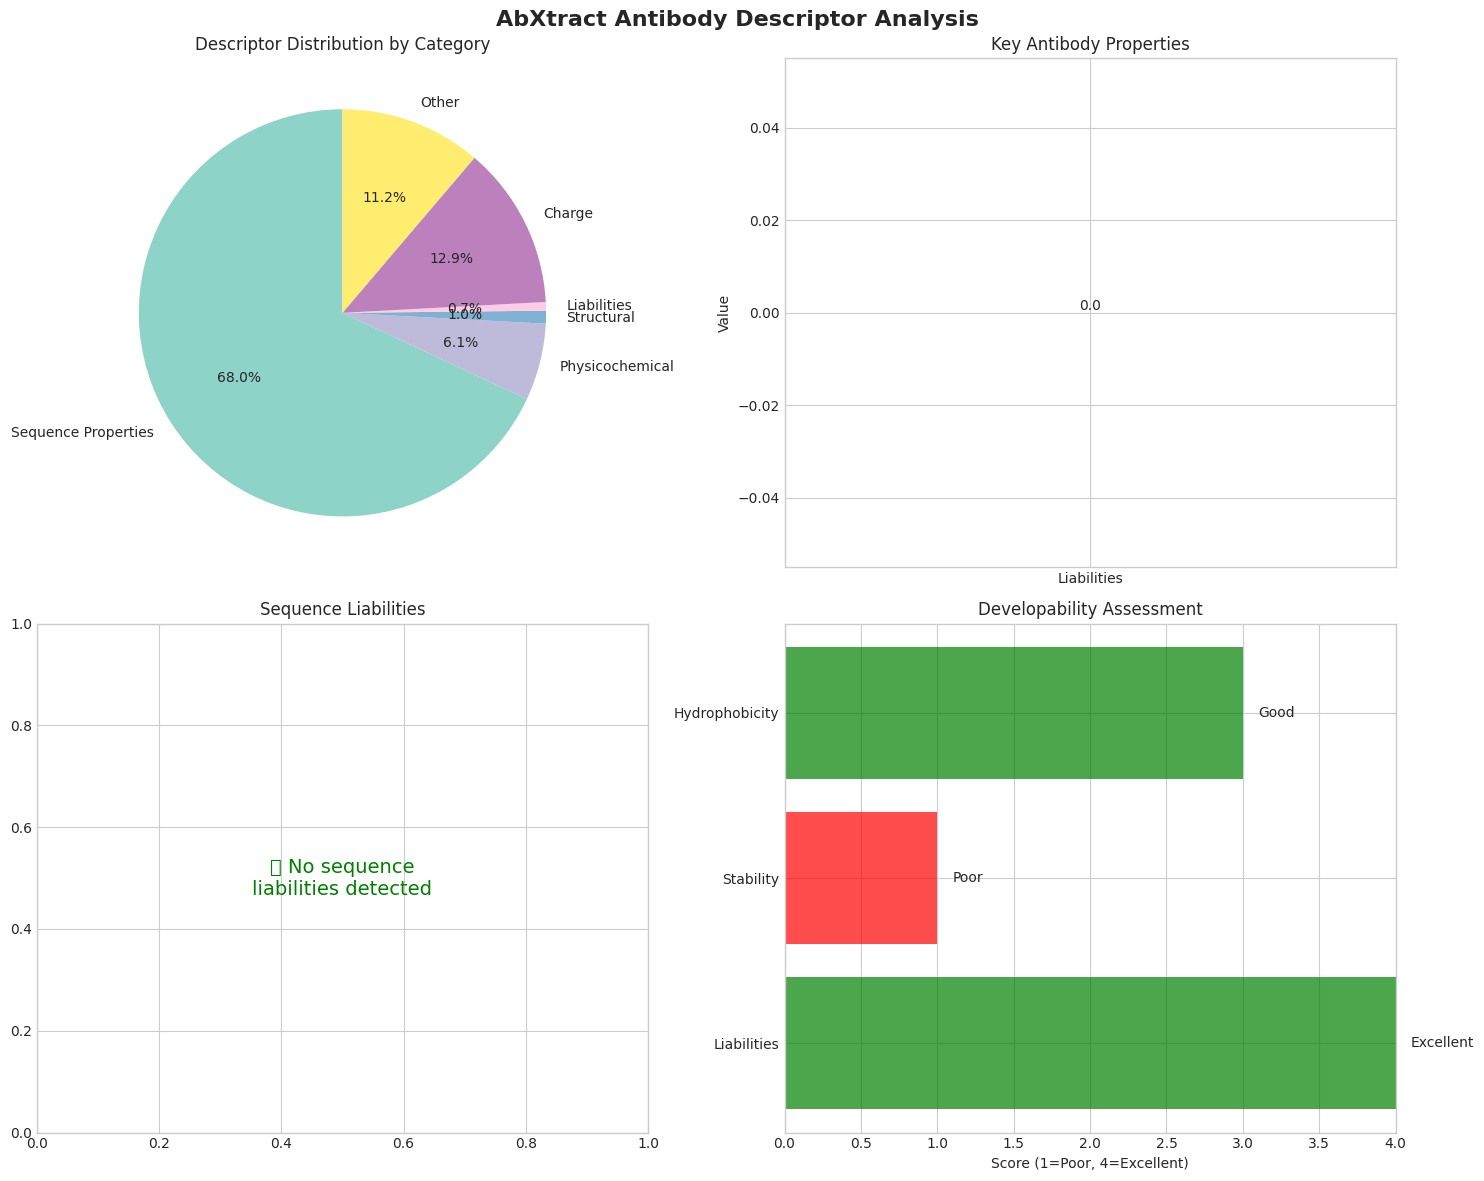

📊 Plot saved to: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test/results/antibody_analysis_summary.png


In [36]:
# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('AbXtract Antibody Descriptor Analysis', fontsize=16, fontweight='bold')

# 1. Descriptor Category Distribution
ax1 = axes[0, 0]
categories = list(descriptor_categories.keys())
counts = [len(descriptor_categories[cat]) for cat in categories if descriptor_categories[cat]]
categories = [cat for cat in categories if descriptor_categories[cat]]

colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
wedges, texts, autotexts = ax1.pie(counts, labels=categories, autopct='%1.1f%%', 
                                   colors=colors, startangle=90)
ax1.set_title('Descriptor Distribution by Category')

# 2. Key Metrics Bar Chart
ax2 = axes[0, 1]
metrics = []
values = []
colors_bar = []

# Add key metrics if available
if 'Total_Liabilities' in complete_results.columns:
    metrics.append('Liabilities')
    values.append(result_row['Total_Liabilities'])
    colors_bar.append('red' if result_row['Total_Liabilities'] > 3 else 'green')

if any(col in complete_results.columns for col in ['Molecular Weight', 'molecular_weight']):
    mw_col = next((col for col in ['Molecular Weight', 'molecular_weight'] 
                   if col in complete_results.columns), None)
    if mw_col:
        metrics.append('MW (kDa)')
        values.append(result_row[mw_col] / 1000)  # Convert to kDa
        colors_bar.append('blue')

if any(col in complete_results.columns for col in ['pI', 'isoelectric_point']):
    pi_col = next((col for col in ['pI', 'isoelectric_point'] 
                   if col in complete_results.columns), None)
    if pi_col:
        metrics.append('pI')
        values.append(result_row[pi_col])
        colors_bar.append('purple')

if metrics:
    bars = ax2.bar(metrics, values, color=colors_bar, alpha=0.7)
    ax2.set_title('Key Antibody Properties')
    ax2.set_ylabel('Value')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f}', ha='center', va='bottom')
else:
    ax2.text(0.5, 0.5, 'No key metrics\navailable to plot', 
             ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Key Metrics (Data Not Available)')

# 3. Liability Breakdown (if available)
ax3 = axes[1, 0]
liability_types = ['N_Glycosylation_Sites', 'Deamidation_Sites', 
                   'Oxidation_Sites', 'Unpaired_Cysteines']
liability_counts = []
liability_labels = []

for liability in liability_types:
    if liability in complete_results.columns:
        count = result_row[liability]
        if count > 0:
            liability_counts.append(count)
            liability_labels.append(liability.replace('_', ' '))

if liability_counts:
    ax3.bar(liability_labels, liability_counts, color='orange', alpha=0.7)
    ax3.set_title('Sequence Liability Breakdown')
    ax3.set_ylabel('Count')
    ax3.tick_params(axis='x', rotation=45)
else:
    ax3.text(0.5, 0.5, '✅ No sequence\nliabilities detected', 
             ha='center', va='center', transform=ax3.transAxes,
             fontsize=14, color='green')
    ax3.set_title('Sequence Liabilities')

# 4. Developability Score Overview
ax4 = axes[1, 1]
score_mapping = {'Excellent': 4, 'Good': 3, 'Moderate': 2, 'Poor': 1}
score_names = list(scores.keys())
score_values = [score_mapping[scores[name]] for name in score_names]
score_colors = ['green' if v >= 3 else 'orange' if v >= 2 else 'red' for v in score_values]

bars = ax4.barh(score_names, score_values, color=score_colors, alpha=0.7)
ax4.set_title('Developability Assessment')
ax4.set_xlabel('Score (1=Poor, 4=Excellent)')
ax4.set_xlim(0, 4)

# Add score labels
for bar, score_name in zip(bars, score_names):
    width = bar.get_width()
    ax4.text(width + 0.1, bar.get_y() + bar.get_height()/2,
            scores[score_name], ha='left', va='center')

plt.tight_layout()
plt.show()

# Save the plot
plot_path = RESULTS_DIR / 'antibody_analysis_summary.png'
fig.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"📊 Plot saved to: {plot_path}")

## 10. Export and Save Results {#export}

Save all results in various formats for further analysis.

In [37]:
# Save results in multiple formats
print("💾 Saving results in multiple formats...")

timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
base_filename = f"antibody_analysis_{timestamp}"

# CSV format
csv_path = RESULTS_DIR / f"{base_filename}.csv"
complete_results.to_csv(csv_path, index=False)
print(f"✅ CSV saved: {csv_path}")

# Excel format with multiple sheets
excel_path = RESULTS_DIR / f"{base_filename}.xlsx"
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    complete_results.to_excel(writer, sheet_name='Complete_Analysis', index=False)
    
    if sequence_results is not None:
        sequence_results.to_excel(writer, sheet_name='Sequence_Only', index=False)
    
    if structure_results is not None:
        structure_results.to_excel(writer, sheet_name='Structure_Only', index=False)
    
    # Add summary sheet
    if hasattr(calc, 'get_detailed_summary'):
        summary = calc.get_detailed_summary()
        summary_df = pd.DataFrame([summary])
        summary_df.to_excel(writer, sheet_name='Summary', index=False)

print(f"✅ Excel saved: {excel_path}")

# JSON format for programmatic access
json_path = RESULTS_DIR / f"{base_filename}.json"
result_dict = complete_results.to_dict(orient='records')[0]

# Add metadata
export_data = {
    'metadata': {
        'timestamp': timestamp,
        'abxtract_version': calc.metadata.get('version', 'unknown'),
        'analysis_type': analysis_type,
        'input_sequences': {
            'heavy_length': len(HEAVY_SEQUENCE),
            'light_length': len(LIGHT_SEQUENCE)
        },
        'pdb_available': pdb_available
    },
    'results': result_dict,
    'summary': summary if 'summary' in locals() else calc.get_summary()
}

import json
with open(json_path, 'w') as f:
    json.dump(export_data, f, indent=2, default=str)
print(f"✅ JSON saved: {json_path}")

print(f"\n📁 All results saved to: {RESULTS_DIR}")

💾 Saving results in multiple formats...
✅ CSV saved: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test/results/antibody_analysis_20250828_093138.csv
✅ Excel saved: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test/results/antibody_analysis_20250828_093138.xlsx
✅ JSON saved: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test/results/antibody_analysis_20250828_093138.json

📁 All results saved to: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test/results


In [38]:
# Create a summary report
report_path = RESULTS_DIR / f"analysis_report_{timestamp}.txt"

with open(report_path, 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("           AbXtract Antibody Analysis Report\n")
    f.write("=" * 60 + "\n\n")
    
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Sample ID: TestAb_Complete\n")
    f.write(f"Analysis Type: {analysis_type}\n\n")
    
    f.write("INPUT SUMMARY\n")
    f.write("-" * 20 + "\n")
    f.write(f"Heavy Chain Length: {len(HEAVY_SEQUENCE)} aa\n")
    f.write(f"Light Chain Length: {len(LIGHT_SEQUENCE)} aa\n")
    f.write(f"Total Length: {len(HEAVY_SEQUENCE + LIGHT_SEQUENCE)} aa\n")
    if pdb_available:
        f.write(f"Structure File: {PDB_FILE.name}\n")
    f.write("\n")
    
    f.write("DESCRIPTOR SUMMARY\n")
    f.write("-" * 20 + "\n")
    f.write(f"Total Descriptors Calculated: {len(complete_results.columns)}\n")
    for category, descriptors in descriptor_categories.items():
        if descriptors:
            f.write(f"{category}: {len(descriptors)} descriptors\n")
    f.write("\n")
    
    f.write("KEY METRICS\n")
    f.write("-" * 20 + "\n")
    result_row = complete_results.iloc[0]
    
    # Sequence metrics
    f.write(f"Antibody Type: {result_row.get('Type', 'Unknown')}\n")
    total_liabilities = result_row.get('Total_Liabilities', 0)
    f.write(f"Total Sequence Liabilities: {total_liabilities}\n")
    
    # Physicochemical metrics
    mw = result_row.get('Molecular Weight', result_row.get('molecular_weight', 'N/A'))
    if mw != 'N/A':
        f.write(f"Molecular Weight: {mw:.1f} Da\n")
    
    pi = result_row.get('pI', result_row.get('isoelectric_point', 'N/A'))
    if pi != 'N/A':
        f.write(f"Isoelectric Point: {pi:.2f}\n")
    
    instability = result_row.get('Instability Index', 'N/A')
    if instability != 'N/A':
        stability_desc = "Stable" if instability < 40 else "Unstable"
        f.write(f"Instability Index: {instability:.2f} ({stability_desc})\n")
    
    gravy = result_row.get('Hydrophobicity', result_row.get('gravy', 'N/A'))
    if gravy != 'N/A':
        hydro_desc = "Hydrophobic" if gravy > 0 else "Hydrophilic"
        f.write(f"GRAVY Score: {gravy:.3f} ({hydro_desc})\n")
    
    f.write("\n")
    
    f.write("DEVELOPABILITY ASSESSMENT\n")
    f.write("-" * 30 + "\n")
    for category, score in scores.items():
        f.write(f"{category}: {score}\n")
    f.write("\n")
    
    if positives:
        f.write("POSITIVE ASPECTS\n")
        f.write("-" * 20 + "\n")
        for positive in positives:
            f.write(f"• {positive}\n")
        f.write("\n")
    
    if issues:
        f.write("AREAS OF CONCERN\n")
        f.write("-" * 20 + "\n")
        for issue in issues:
            f.write(f"• {issue}\n")
        f.write("\n")
    
    f.write("FILES GENERATED\n")
    f.write("-" * 20 + "\n")
    f.write(f"• Complete Results (CSV): {csv_path.name}\n")
    f.write(f"• Complete Results (Excel): {excel_path.name}\n")
    f.write(f"• Complete Results (JSON): {json_path.name}\n")
    f.write(f"• Analysis Plot: antibody_analysis_summary.png\n")
    f.write(f"• This Report: {report_path.name}\n\n")
    
    f.write("Generated by AbXtract - Antibody Descriptor Analysis Toolkit\n")

print(f"📄 Analysis report saved: {report_path}")

📄 Analysis report saved: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test/results/analysis_report_20250828_093138.txt


## 11. Testing Summary

Final summary of all testing performed.

In [39]:
print("🎉 ABXTRACT TESTING COMPLETED SUCCESSFULLY! 🎉")
print("=" * 60)
print(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Analysis Type: {analysis_type}")
print(f"Total Descriptors: {len(complete_results.columns)}")
print(f"Results Saved to: {RESULTS_DIR}")

print("\n✅ TESTS COMPLETED:")
print("   • Configuration system")
print("   • Individual calculators")
print("   • Sequence analysis")
if pdb_available:
    print("   • Structure analysis")
print("   • Combined analysis")
print("   • Data visualization")
print("   • Multiple export formats")

print("\n📊 DESCRIPTOR CATEGORIES TESTED:")
for category, descriptors in descriptor_categories.items():
    if descriptors:
        print(f"   • {category}: {len(descriptors)} descriptors")

print("\n🛠️ EXTERNAL TOOLS STATUS:")
for tool, available in tool_status.items():
    status = "Available" if available else "Not Available"
    print(f"   • {tool}: {status}")

print("\n📁 OUTPUT FILES:")
for file in sorted(RESULTS_DIR.glob(f"*{timestamp}*")):
    print(f"   • {file.name}")

print("\n" + "=" * 60)
print("AbXtract is ready for production use! 🚀")
print("For more information, check the generated files and documentation.")

🎉 ABXTRACT TESTING COMPLETED SUCCESSFULLY! 🎉
Analysis Date: 2025-08-28 09:31:40
Analysis Type: Sequence + Structure
Total Descriptors: 294
Results Saved to: /home/HX46_FR5/repo_perso/AbXtract/examples/data/test/results

✅ TESTS COMPLETED:
   • Configuration system
   • Individual calculators
   • Sequence analysis
   • Structure analysis
   • Combined analysis
   • Data visualization
   • Multiple export formats

📊 DESCRIPTOR CATEGORIES TESTED:
   • Sequence Properties: 200 descriptors
   • Physicochemical: 18 descriptors
   • Structural: 3 descriptors
   • Liabilities: 2 descriptors
   • Charge: 38 descriptors
   • Other: 33 descriptors

🛠️ EXTERNAL TOOLS STATUS:
   • dssp: Available
   • propka: Available
   • arpeggio: Available
   • reduce: Not Available
   • muscle: Available

📁 OUTPUT FILES:
   • analysis_report_20250828_093138.txt
   • antibody_analysis_20250828_093138.csv
   • antibody_analysis_20250828_093138.json
   • antibody_analysis_20250828_093138.xlsx

AbXtract is ready 